---
## Configuration et Importations

In [67]:
# Installation des bibliothèques requises pour Google Colab
!pip install apyori mlxtend openpyxl

In [68]:
# Importations standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Importations Apriori
from apyori import apriori

# Importations FP-Growth et génération de règles
from mlxtend.frequent_patterns import fpgrowth, apriori as mlx_apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Définir les options d'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# URL de base pour les données
base_url = 'https://raw.githubusercontent.com/NassimZahri/Data_Mining/main/data/'

print(" Toutes les bibliothèques ont été importées avec succès !")

 Toutes les bibliothèques ont été importées avec succès !


---
# Partie 0 : Mise en route (Apriori sur un petit jeu de données)

**Objectif :** Rafraîchir la compréhension du fonctionnement d'Apriori et de la signification des métriques.

In [69]:
# Charger le petit jeu de données de démonstration
# Utiliser header=None car le jeu de données peut ne pas avoir d'en-tête (format panier)
order_data = pd.read_csv(f"{base_url}order_data.csv", header=None)
print("Forme des données de commande :", order_data.shape)
print("\nNoms des colonnes :", order_data.columns.tolist())
print("\nQuelques premières lignes :")
order_data.head(10)

Forme des données de commande : (20, 1)

Noms des colonnes : [0]

Quelques premières lignes :


,0
0,toothpaste brush milk cereals honey bread butter cheese yogurt
1,milk cereals honey bread cheese razor gel shampoo
2,milk cereals honey cheese soap shampoo
3,honey bread butter cheese mouthwash toothpaste
4,cereals honey bread butter gel soap
5,cheesse yogurt milk cereals honey shampoo gel
6,honey bread cheese razor butter yogurt
7,honey bread cheese butter milk
8,cereals butter cookies chips
9,cerals cheese yogurt cookies chips


In [70]:
# Explorer le jeu de données
print("Informations sur le jeu de données :")
print(order_data.info())
print("\n" + "="*50)
print("\nStatistiques descriptives :")
order_data.describe(include='all')

Informations sur le jeu de données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       20 non-null     object
dtypes: object(1)
memory usage: 292.0+ bytes
None


Statistiques descriptives :


,0
count,20
unique,20
top,toothpaste brush milk cereals honey bread butter cheese yogurt
freq,1


In [71]:
# Construire une liste de listes (chaque transaction = liste d'articles)
# La structure du jeu de données peut varier, alors inspectons et adaptons

# Vérifier si nous devons grouper par transaction/facture
if 'InvoiceNo' in order_data.columns or 'Transaction' in order_data.columns:
    # Grouper par transaction
    trans_col = 'InvoiceNo' if 'InvoiceNo' in order_data.columns else 'Transaction'
    item_col = [col for col in order_data.columns if 'product' in col.lower() or 'item' in col.lower() or 'description' in col.lower()][0]
    transactions_list = order_data.groupby(trans_col)[item_col].apply(list).tolist()
else:
    # Chaque ligne peut déjà être une transaction avec plusieurs articles dans les colonnes
    # Convertir les articles par ligne en listes
    transactions_list = []
    for idx, row in order_data.iterrows():
        # Pour les données de panier (sans en-tête), les articles sont dans les colonnes
        # Filtrer les valeurs NaN et convertir en chaîne
        items = [str(item) for item in row.values if pd.notna(item) and str(item).strip()]
        if items:
            transactions_list.append(items)

print(f"Nombre de transactions : {len(transactions_list)}")
print("\n5 premières transactions :")
for i, trans in enumerate(transactions_list[:5]):
    print(f"Transaction {i+1} : {trans}")

Nombre de transactions : 20

5 premières transactions :
Transaction 1 : ['toothpaste brush milk cereals honey bread butter cheese yogurt']
Transaction 2 : ['milk cereals honey bread cheese razor gel shampoo']
Transaction 3 : ['milk cereals honey cheese soap shampoo']
Transaction 4 : ['honey bread butter cheese mouthwash toothpaste']
Transaction 5 : ['cereals honey bread butter gel soap']


In [72]:
# Appliquer l'algorithme Apriori avec les paramètres spécifiés
apriori_results = list(apriori(
    transactions_list,
    min_support=0.25,
    min_confidence=0.2,
    min_lift=2,
    min_length=2
))

print(f"Nombre de règles trouvées : {len(apriori_results)}")

Nombre de règles trouvées : 0


In [73]:
# Fonction utilitaire pour afficher joliment les résultats d'Apriori
def display_apriori_rules(results, num_rules=5):
    """Afficher les règles Apriori dans un format lisible"""
    rules_data = []
    
    for item in results:
        # Obtenir les statistiques de la règle
        for stat in item.ordered_statistics:
            antecedent = list(stat.items_base)
            consequent = list(stat.items_add)
            
            if antecedent:  # Inclure uniquement les règles réelles (pas seulement les ensembles d'articles fréquents)
                rules_data.append({
                    'Antécédent (X)': str(antecedent),
                    'Conséquent (Y)': str(consequent),
                    'Support': round(item.support, 4),
                    'Confiance': round(stat.confidence, 4),
                    'Lift': round(stat.lift, 4)
                })
    
    # Créer un DataFrame et supprimer les doublons
    if not rules_data:
        print("Aucune règle trouvée !")
        return pd.DataFrame(columns=['Antécédent (X)', 'Conséquent (Y)', 'Support', 'Confiance', 'Lift'])

    rules_df = pd.DataFrame(rules_data).drop_duplicates()
    rules_df = rules_df.sort_values('Lift', ascending=False).head(num_rules)
    
    return rules_df

# Afficher les règles
rules_df_part0 = display_apriori_rules(apriori_results, num_rules=5)
print("Meilleures règles d'association (Partie 0) :")
rules_df_part0

Aucune règle trouvée !
Meilleures règles d'association (Partie 0) :


,Antécédent (X),Conséquent (Y),Support,Confiance,Lift


In [74]:
# Interprétation détaillée des règles sélectionnées
print("=" * 80)
print("INTERPRÉTATION DÉTAILLÉE DES RÈGLES (Partie 0)")
print("=" * 80)

for idx, row in rules_df_part0.head(3).iterrows():
    print(f"\n📌 RÈGLE {idx+1} : {row['Antécédent (X)']} ⇒ {row['Conséquent (Y)']}")
    print("-" * 60)
    print(f"    Support : {row['Support']:.2%}")
    print(f"      → Cette combinaison apparaît dans {row['Support']*100:.1f}% de toutes les transactions")
    print(f"      → Business : C'est un modèle d'achat {'courant' if row['Support'] > 0.3 else 'modérément courant'}")
    
    print(f"\n    Confiance : {row['Confiance']:.2%}")
    print(f"      → {row['Confiance']*100:.1f}% des clients qui achètent {row['Antécédent (X)']} achètent également {row['Conséquent (Y)']}")
    print(f"      → Business : Pouvoir prédictif {'fort' if row['Confiance'] > 0.6 else 'modéré'} pour les recommandations")
    
    print(f"\n    Lift : {row['Lift']:.2f}")
    print(f"      → Les clients sont {row['Lift']:.1f} fois plus susceptibles d'acheter {row['Conséquent (Y)']} lorsqu'ils achètent {row['Antécédent (X)']}")
    print(f"      → Business : {'Excellent' if row['Lift'] > 2 else 'Bon'} candidat pour la vente croisée")

INTERPRÉTATION DÉTAILLÉE DES RÈGLES (Partie 0)


---
# Partie 1 : Préparation des données réelles

**Objectif :** Préparer le jeu de données transactionnel à partir des données brutes

In [75]:
# Charger le jeu de données réel (Online Retail)
try:
    # Essayer de charger le fichier Excel - gérer les espaces dans l'URL
    excel_url = f"{base_url}Online Retail.xlsx".replace(" ", "%20")
    retail_data = pd.read_excel(excel_url)
    print("Chargé Online Retail.xlsx")
except Exception as e1:
    print(f"Impossible de charger l'Excel : {e1}")
    try:
        # Essayer l'alternative CSV - ajouter l'encodage pour les caractères spéciaux
        retail_data = pd.read_csv(f"{base_url}transaction_dataset.csv", encoding='latin-1')
        print("Chargé transaction_dataset.csv")
    except Exception as e2:
        print(f"Erreur lors du chargement du CSV distant : {e2}")
        try:
            # Essayer le fichier local si le distant échoue
            retail_data = pd.read_csv("../data/transaction_dataset.csv", encoding='latin-1')
            print("Chargé transaction_dataset.csv local")
        except Exception as e3:
            print(f"Erreur lors du chargement des données locales : {e3}")
            # Créer un repli pour essayer une autre approche
            retail_data = pd.read_csv(f"{base_url}Online_Retail.csv", encoding='latin-1')
            print("Chargé Online_Retail.csv")

print("\nForme du jeu de données :", retail_data.shape)
print("\nColonnes :", retail_data.columns.tolist())

Chargé Online Retail.xlsx

Forme du jeu de données : (541909, 8)

Colonnes : ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [76]:
# Afficher les premières lignes
print("10 premières lignes du jeu de données :")
retail_data.head(10)

10 premières lignes du jeu de données :


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [77]:
# Exploration des données
print("Informations sur le jeu de données :")
print(retail_data.info())
print("\n" + "="*50)
print("\nValeurs manquantes :")
print(retail_data.isnull().sum())
print("\n" + "="*50)
print("\nStatistiques de base :")
retail_data.describe()

Informations sur le jeu de données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


Valeurs manquantes :
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


Statistiques de base :


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [78]:
# Nettoyage des données

# Identifier les noms de colonnes corrects (peuvent varier selon les jeux de données)
print("Colonnes disponibles :", retail_data.columns.tolist())

# Mappage standard des colonnes
col_mapping = {
    'invoice': None,
    'product': None,
    'quantity': None,
    'country': None
}

# Trouver les bonnes colonnes
for col in retail_data.columns:
    col_lower = col.lower()
    if 'invoice' in col_lower:
        col_mapping['invoice'] = col
    elif 'description' in col_lower or 'stock' in col_lower or 'product' in col_lower:
        if col_mapping['product'] is None or 'description' in col_lower:
            col_mapping['product'] = col
    elif 'quantity' in col_lower or 'qty' in col_lower:
        col_mapping['quantity'] = col
    elif 'country' in col_lower:
        col_mapping['country'] = col

print("\nMappage des colonnes :", col_mapping)

Colonnes disponibles : ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Mappage des colonnes : {'invoice': 'InvoiceDate', 'product': 'Description', 'quantity': 'Quantity', 'country': 'Country'}


In [79]:
# Nettoyer les données
df_clean = retail_data.copy()

# Supprimer les lignes avec facture ou produit manquant
if col_mapping['invoice']:
    df_clean = df_clean.dropna(subset=[col_mapping['invoice']])
if col_mapping['product']:
    df_clean = df_clean.dropna(subset=[col_mapping['product']])

# Supprimer les commandes annulées (si la facture commence par 'C')
if col_mapping['invoice']:
    df_clean = df_clean[~df_clean[col_mapping['invoice']].astype(str).str.startswith('C')]

# Supprimer les quantités négatives
if col_mapping['quantity']:
    df_clean = df_clean[df_clean[col_mapping['quantity']] > 0]

# Supprimer les articles avec des descriptions vides
if col_mapping['product']:
    df_clean = df_clean[df_clean[col_mapping['product']].astype(str).str.strip() != '']

print(f"Lignes originales : {len(retail_data)}")
print(f"Après nettoyage : {len(df_clean)}")
print(f"Supprimées : {len(retail_data) - len(df_clean)} lignes ({(len(retail_data) - len(df_clean))/len(retail_data)*100:.1f}%)")

Lignes originales : 541909
Après nettoyage : 530693
Supprimées : 11216 lignes (2.1%)


In [80]:
# Construire le jeu de données transactionnel
# Chaque transaction = une facture
# Chaque transaction = liste de produits achetés dans cette facture

invoice_col = col_mapping['invoice']
product_col = col_mapping['product']

# Grouper par facture et collecter tous les produits
transactions_real = df_clean.groupby(invoice_col)[product_col].apply(list).reset_index()
transactions_list_real = transactions_real[product_col].tolist()

# Nettoyer les transactions (supprimer les doublons au sein de chaque transaction)
transactions_list_real = [list(set([str(item).strip() for item in trans if pd.notna(item)])) for trans in transactions_list_real]

# Supprimer les transactions vides
transactions_list_real = [trans for trans in transactions_list_real if len(trans) > 0]

print(f"\n STATISTIQUES DU JEU DE DONNÉES TRANSACTIONNEL")
print("="*50)
print(f"Nombre total de transactions : {len(transactions_list_real)}")
print(f"Nombre d'articles uniques : {len(set([item for trans in transactions_list_real for item in trans]))}")
print(f"Moyenne d'articles par transaction : {np.mean([len(trans) for trans in transactions_list_real]):.2f}")
print(f"Nombre max d'articles dans une transaction : {max([len(trans) for trans in transactions_list_real])}")
print(f"Nombre min d'articles dans une transaction : {min([len(trans) for trans in transactions_list_real])}")


 STATISTIQUES DU JEU DE DONNÉES TRANSACTIONNEL
Nombre total de transactions : 18641
Nombre d'articles uniques : 4065
Moyenne d'articles par transaction : 27.77
Nombre max d'articles dans une transaction : 1108
Nombre min d'articles dans une transaction : 1


In [81]:
# Afficher 3 exemples de transactions
print("\n EXEMPLES DE TRANSACTIONS")
print("="*50)
for i in range(3):
    print(f"\nTransaction {i+1} ({len(transactions_list_real[i])} articles) :")
    print(f"  Articles : {transactions_list_real[i][:5]}{'...' if len(transactions_list_real[i]) > 5 else ''}")


 EXEMPLES DE TRANSACTIONS

Transaction 1 (7 articles) :
  Articles : ['WHITE HANGING HEART T-LIGHT HOLDER', 'GLASS STAR FROSTED T-LIGHT HOLDER', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'WHITE METAL LANTERN', 'RED WOOLLY HOTTIE WHITE HEART.']...

Transaction 2 (2 articles) :
  Articles : ['HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT']

Transaction 3 (16 articles) :
  Articles : ['BOX OF VINTAGE JIGSAW BLOCKS', 'LOVE BUILDING BLOCK WORD', 'FELTCRAFT PRINCESS CHARLOTTE DOLL', 'BLUE COAT RACK PARIS FASHION', 'JAM MAKING SET WITH JARS']...


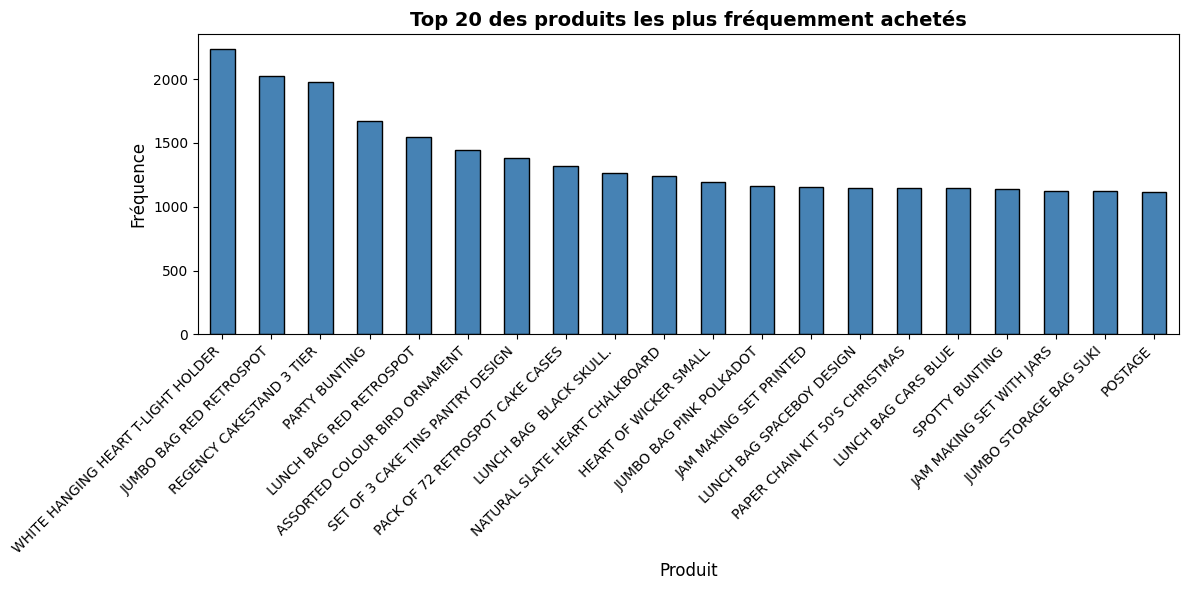

In [82]:
# Visualiser les produits les plus vendus
all_items = [item for trans in transactions_list_real for item in trans]
item_counts = pd.Series(all_items).value_counts().head(20)

plt.figure(figsize=(12, 6))
item_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Top 20 des produits les plus fréquemment achetés', fontsize=14, fontweight='bold')
plt.xlabel('Produit', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
# Partie 2 : Extraction de règles avec FP-Growth

**Objectif :** Appliquer l'algorithme FP-Growth pour extraire les ensembles d'articles fréquents et générer des règles d'association

In [83]:
# Limiter les transactions pour la performance (si le jeu de données est trop volumineux)
if len(transactions_list_real) > 10000:
    print(f"Grand jeu de données détecté ({len(transactions_list_real)} transactions)")
    print("Utilisation d'un échantillon de 10 000 transactions pour la performance")
    transactions_sample = transactions_list_real[:10000]
else:
    transactions_sample = transactions_list_real

print(f"Utilisation de {len(transactions_sample)} transactions pour l'analyse")

Grand jeu de données détecté (18641 transactions)
Utilisation d'un échantillon de 10 000 transactions pour la performance
Utilisation de 10000 transactions pour l'analyse


In [84]:
# Étape 1 : Encoder les transactions à l'aide de TransactionEncoder
te = TransactionEncoder()
te_array = te.fit_transform(transactions_sample)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

print(f"Forme du DataFrame encodé : {df_encoded.shape}")
print(f"Nombre d'articles uniques (colonnes) : {len(df_encoded.columns)}")
print("\nÉchantillon de données encodées (5 premières lignes, 10 premières colonnes) :")
df_encoded.iloc[:5, :10]

Forme du DataFrame encodé : (10000, 3599)
Nombre d'articles uniques (colonnes) : 3599

Échantillon de données encodées (5 premières lignes, 10 premières colonnes) :


,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


In [85]:
# Étape 2 : Appliquer l'algorithme FP-Growth
print("Application de l'algorithme FP-Growth...")
start_time = time.time()

# Utiliser un min_support de 0.02 (2%)
frequent_itemsets_fpg = fpgrowth(df_encoded, min_support=0.02, use_colnames=True)

fpg_time = time.time() - start_time
print(f"FP-Growth terminé en {fpg_time:.2f} secondes")
print(f"Nombre d'ensembles d'articles fréquents trouvés : {len(frequent_itemsets_fpg)}")

Application de l'algorithme FP-Growth...
FP-Growth terminé en 8.31 secondes
Nombre d'ensembles d'articles fréquents trouvés : 446


In [86]:
# Afficher les 10 ensembles d'articles les plus fréquents par support
print("\n TOP 10 DES ENSEMBLES D'ARTICLES FRÉQUENTS (par Support)")
print("="*60)
top_itemsets = frequent_itemsets_fpg.nlargest(10, 'support')
for idx, row in top_itemsets.iterrows():
    items = list(row['itemsets'])
    print(f"Support : {row['support']:.4f} | Articles : {items}")


 TOP 10 DES ENSEMBLES D'ARTICLES FRÉQUENTS (par Support)
Support : 0.1380 | Articles : ['WHITE HANGING HEART T-LIGHT HOLDER']
Support : 0.1219 | Articles : ['REGENCY CAKESTAND 3 TIER']
Support : 0.1103 | Articles : ['PARTY BUNTING']
Support : 0.1102 | Articles : ['JUMBO BAG RED RETROSPOT']
Support : 0.0872 | Articles : ['LUNCH BAG RED RETROSPOT']
Support : 0.0798 | Articles : ['PACK OF 72 RETROSPOT CAKE CASES']
Support : 0.0767 | Articles : ['ASSORTED COLOUR BIRD ORNAMENT']
Support : 0.0747 | Articles : ['SET OF 3 CAKE TINS PANTRY DESIGN']
Support : 0.0742 | Articles : ['NATURAL SLATE HEART CHALKBOARD']
Support : 0.0708 | Articles : ['HEART OF WICKER SMALL']


In [87]:
# Étape 3 : Générer des règles d'association
rules_fpg = association_rules(frequent_itemsets_fpg, metric="confidence", min_threshold=0.5)
print(f"Nombre de règles d'association générées : {len(rules_fpg)}")

# Trier par lift
rules_fpg_sorted = rules_fpg.sort_values(['lift', 'confidence'], ascending=[False, False])

Nombre de règles d'association générées : 79


In [88]:
# Afficher les meilleures règles
print("\n TOP 20 DES RÈGLES D'ASSOCIATION (par Lift)")
print("="*80)
top_rules = rules_fpg_sorted.head(20)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
top_rules


 TOP 20 DES RÈGLES D'ASSOCIATION (par Lift)


,antecedents,consequents,support,confidence,lift
28,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.0238,0.683908,23.183324
27,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.0238,0.806780,23.183324
75,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER)",0.0302,0.725962,15.380541
72,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER)",(PINK REGENCY TEACUP AND SAUCER),0.0302,0.639831,15.380541
74,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY TEACUP AND SAUCER)",(GREEN REGENCY TEACUP AND SAUCER),0.0302,0.926380,14.845839
73,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY TEACUP AND SAUCER)",(ROSES REGENCY TEACUP AND SAUCER),0.0302,0.870317,13.727398
68,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.0347,0.834135,13.367542
67,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.0347,0.556090,13.367542
38,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.0293,0.631466,12.705544
39,(SPACEBOY LUNCH BOX),(DOLLY GIRL LUNCH BOX),0.0293,0.589537,12.705544


In [89]:
# Étape 4 : Sélectionner 5 règles intéressantes
# Critères : support ni trop bas ni trop élevé, confiance élevée, lift > 1.2

# Filtrer pour les bonnes règles
good_rules = rules_fpg_sorted[
    (rules_fpg_sorted['support'] >= 0.01) & 
    (rules_fpg_sorted['support'] <= 0.1) &
    (rules_fpg_sorted['confidence'] >= 0.5) &
    (rules_fpg_sorted['lift'] > 1.2)
].head(5)

if len(good_rules) < 5:
    # Assouplir les critères s'il n'y a pas assez de règles
    good_rules = rules_fpg_sorted[
        (rules_fpg_sorted['lift'] > 1) &
        (rules_fpg_sorted['confidence'] >= 0.4)
    ].head(5)

print(f"Sélection de {len(good_rules)} règles intéressantes :")
good_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

Sélection de 5 règles intéressantes :


,antecedents,consequents,support,confidence,lift
28,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.0238,0.683908,23.183324
27,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.0238,0.806780,23.183324
75,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER)",0.0302,0.725962,15.380541
72,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER)",(PINK REGENCY TEACUP AND SAUCER),0.0302,0.639831,15.380541
74,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY TEACUP AND SAUCER)",(GREEN REGENCY TEACUP AND SAUCER),0.0302,0.926380,14.845839


In [90]:
# Interprétation détaillée des règles sélectionnées avec recommandations marketing
print("\n" + "="*80)
print(" INTERPRÉTATION DÉTAILLÉE DES RÈGLES ET RECOMMANDATIONS MARKETING")
print("="*80)

for idx, (_, row) in enumerate(good_rules.iterrows()):
    antecedent = list(row['antecedents'])
    consequent = list(row['consequents'])
    
    print(f"\n{'='*80}")
    print(f"📌 RÈGLE {idx+1} : {antecedent} ⇒ {consequent}")
    print("="*80)
    
    # Description en langage clair
    print(f"\n En langage clair :")
    print(f"   \"Les clients qui achètent {', '.join(antecedent[:2])}{'...' if len(antecedent) > 2 else ''}")
    print(f"    achètent souvent aussi {', '.join(consequent[:2])}{'...' if len(consequent) > 2 else ''}\"")
    
    # Explication des métriques
    print(f"\n Interprétation des métriques :")
    print(f"   • Support : {row['support']:.2%}")
    print(f"     → Cette combinaison apparaît dans {row['support']*100:.1f}% de toutes les transactions")
    
    print(f"\n   • Confiance : {row['confidence']:.2%}")
    print(f"     → Lorsque les clients achètent {antecedent[0]}, il y a {row['confidence']*100:.1f}% de chances")
    print(f"       qu'ils achètent également {consequent[0]}")
    
    print(f"\n   • Lift : {row['lift']:.2f}")
    print(f"     → Les clients sont {row['lift']:.1f} fois plus susceptibles d'acheter {consequent[0]}")
    print(f"       lorsqu'ils achètent {antecedent[0]} par rapport au hasard")
    
    # Recommandations marketing
    print(f"\n RECOMMANDATIONS MARKETING :")
    recommendations = [
        f"   1. OFFRE DE LOT : Créer un lot à prix réduit avec {antecedent[0]} et {consequent[0]}",
        f"   2. VENTE CROISÉE : Lorsque le client ajoute {antecedent[0]} au panier, afficher 'Fréquemment achetés ensemble'",
        f"   3. AGENCEMENT DU MAGASIN : Placer {antecedent[0]} et {consequent[0]} dans des allées/sections proches",
        f"   4. CAMPAGNE EMAIL : Cibler les clients ayant acheté {antecedent[0]} avec des promotions pour {consequent[0]}",
        f"   5. PROGRAMME DE FIDÉLITÉ : Offrir des points bonus lors de l'achat des deux articles ensemble"
    ]
    for rec in recommendations[:3]:  # Afficher les 3 meilleures recommandations
        print(rec)


 INTERPRÉTATION DÉTAILLÉE DES RÈGLES ET RECOMMANDATIONS MARKETING

📌 RÈGLE 1 : ['SET/6 RED SPOTTY PAPER PLATES'] ⇒ ['SET/6 RED SPOTTY PAPER CUPS']

 En langage clair :
   "Les clients qui achètent SET/6 RED SPOTTY PAPER PLATES
    achètent souvent aussi SET/6 RED SPOTTY PAPER CUPS"

 Interprétation des métriques :
   • Support : 2.38%
     → Cette combinaison apparaît dans 2.4% de toutes les transactions

   • Confiance : 68.39%
     → Lorsque les clients achètent SET/6 RED SPOTTY PAPER PLATES, il y a 68.4% de chances
       qu'ils achètent également SET/6 RED SPOTTY PAPER CUPS

   • Lift : 23.18
     → Les clients sont 23.2 fois plus susceptibles d'acheter SET/6 RED SPOTTY PAPER CUPS
       lorsqu'ils achètent SET/6 RED SPOTTY PAPER PLATES par rapport au hasard

 RECOMMANDATIONS MARKETING :
   1. OFFRE DE LOT : Créer un lot à prix réduit avec SET/6 RED SPOTTY PAPER PLATES et SET/6 RED SPOTTY PAPER CUPS
   2. VENTE CROISÉE : Lorsque le client ajoute SET/6 RED SPOTTY PAPER PLATES au pa

---
# Partie 3 : Comparaison Apriori vs FP-Growth

**Objectif :** Comparer les performances et les résultats des deux algorithmes

In [91]:
# Appliquer Apriori sur le même jeu de données
print("Application de l'algorithme Apriori (version mlxtend)...")
start_time = time.time()

frequent_itemsets_apr = mlx_apriori(df_encoded, min_support=0.02, use_colnames=True)

apr_time = time.time() - start_time
print(f"Apriori terminé en {apr_time:.2f} secondes")
print(f"Nombre d'ensembles d'articles fréquents trouvés : {len(frequent_itemsets_apr)}")

Application de l'algorithme Apriori (version mlxtend)...
Apriori terminé en 21.44 secondes
Nombre d'ensembles d'articles fréquents trouvés : 446


In [92]:
# Générer des règles à partir d'Apriori
rules_apr = association_rules(frequent_itemsets_apr, metric="confidence", min_threshold=0.5)
print(f"Nombre de règles d'association d'Apriori : {len(rules_apr)}")

Nombre de règles d'association d'Apriori : 79


In [93]:
# Tableau de comparaison
print("\n" + "="*80)
print(" COMPARAISON APRIORI VS FP-GROWTH")
print("="*80)

comparison_data = {
    'Métrique': ['Temps de calcul (secondes)', 'Ensembles d\'articles fréquents trouvés', 'Règles d\'association générées'],
    'Apriori': [f'{apr_time:.2f}', len(frequent_itemsets_apr), len(rules_apr)],
    'FP-Growth': [f'{fpg_time:.2f}', len(frequent_itemsets_fpg), len(rules_fpg)]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))


 COMPARAISON APRIORI VS FP-GROWTH
                              Métrique Apriori FP-Growth
            Temps de calcul (secondes)   21.44      8.31
Ensembles d'articles fréquents trouvés     446       446
         Règles d'association générées      79        79


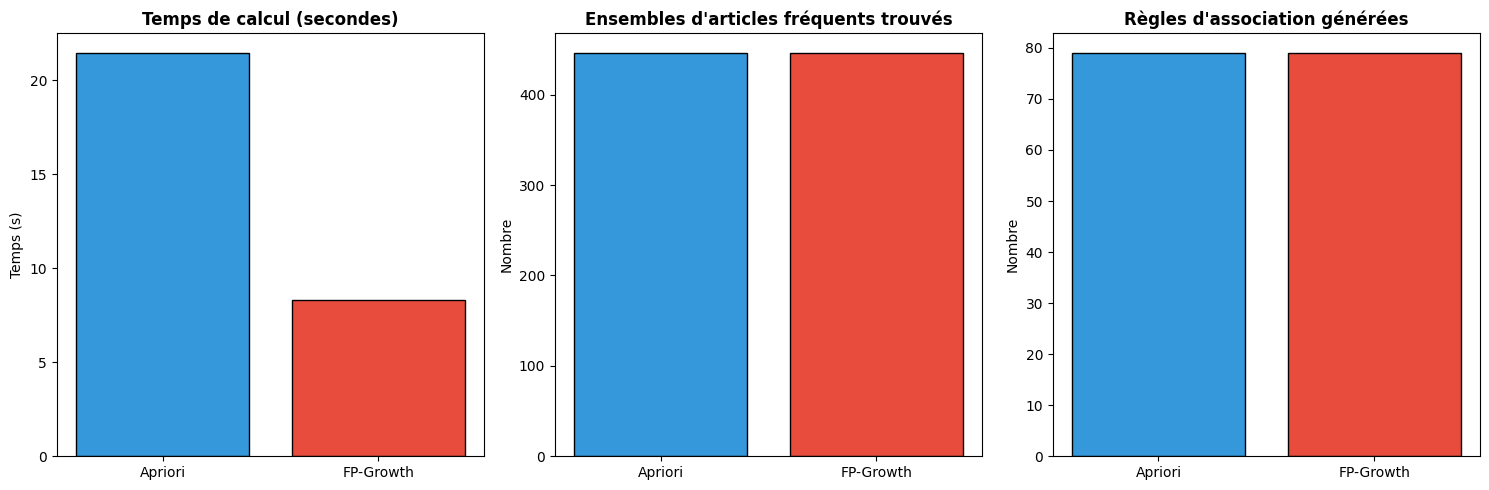

In [94]:
# Visualisation de la comparaison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Comparaison du temps
axes[0].bar(['Apriori', 'FP-Growth'], [apr_time, fpg_time], color=['#3498db', '#e74c3c'], edgecolor='black')
axes[0].set_title('Temps de calcul (secondes)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Temps (s)')

# Comparaison des ensembles d'articles
axes[1].bar(['Apriori', 'FP-Growth'], [len(frequent_itemsets_apr), len(frequent_itemsets_fpg)], 
            color=['#3498db', '#e74c3c'], edgecolor='black')
axes[1].set_title('Ensembles d\'articles fréquents trouvés', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Nombre')

# Comparaison des règles
axes[2].bar(['Apriori', 'FP-Growth'], [len(rules_apr), len(rules_fpg)], 
            color=['#3498db', '#e74c3c'], edgecolor='black')
axes[2].set_title('Règles d\'association générées', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Nombre')

plt.tight_layout()
plt.show()

In [95]:
# Analyse détaillée
print("\n" + "="*80)
print(" ANALYSE DÉTAILLÉE DE LA COMPARAISON")
print("="*80)

print("\n1️ TEMPS DE CALCUL :")
if fpg_time < apr_time:
    speedup = apr_time / fpg_time if fpg_time > 0 else float('inf')
    print(f"   FP-Growth est {speedup:.1f} fois plus rapide qu'Apriori")
    print("   → FP-Growth ne scanne la base de données que deux fois (construction de l'arbre FP + minage)")
    print("   → Apriori nécessite plusieurs scans de la base de données (un par taille d'ensemble d'articles)")
else:
    print("   Apriori et FP-Growth ont des performances similaires sur ce jeu de données")

print("\n2️ NOMBRE DE RÉSULTATS :")
print(f"   Les deux algorithmes ont trouvé le même nombre d'ensembles d'articles et de règles")
print(f"   → C'est attendu car ils implémentent le même concept sous-jacent")
print(f"   → Les différences n'apparaissent que dans l'efficacité, pas dans les résultats")

print("\n3️ LISIBILITÉ :")
print("   Les deux algorithmes produisent des formats de règles identiques")
print("   → Le défi est de filtrer les règles importantes du bruit")
print("   → Utilisez lift > 1.2 et confiance > 50% pour des règles exploitables")


 ANALYSE DÉTAILLÉE DE LA COMPARAISON

1️ TEMPS DE CALCUL :
   FP-Growth est 2.6 fois plus rapide qu'Apriori
   → FP-Growth ne scanne la base de données que deux fois (construction de l'arbre FP + minage)
   → Apriori nécessite plusieurs scans de la base de données (un par taille d'ensemble d'articles)

2️ NOMBRE DE RÉSULTATS :
   Les deux algorithmes ont trouvé le même nombre d'ensembles d'articles et de règles
   → C'est attendu car ils implémentent le même concept sous-jacent
   → Les différences n'apparaissent que dans l'efficacité, pas dans les résultats

3️ LISIBILITÉ :
   Les deux algorithmes produisent des formats de règles identiques
   → Le défi est de filtrer les règles importantes du bruit
   → Utilisez lift > 1.2 et confiance > 50% pour des règles exploitables


In [96]:
# Recommandation finale
print("\n" + "="*80)
print(" RECOMMANDATION FINALE")
print("="*80)

print("""
Pour ce type de données de transactions de détail, je recommande :

 FP-GROWTH pour :
   • Les grands jeux de données (>10 000 transactions)
   • Les besoins d'analyse en temps réel ou fréquents
   • Les environnements de production avec des contraintes de performance

 APRIORI pour :
   • Des fins éducatives (plus facile à comprendre étape par étape)
   • Les petits jeux de données
   • Lorsque des résultats intermédiaires sont nécessaires

 LIMITES des règles d'association sur ce jeu de données :
   1. Corrélation ≠ Causalité : Les règles montrent la cooccurrence, pas l'effet de cause à effet
   2. Biais de popularité : Les articles populaires apparaissent dans de nombreuses règles indépendamment de l'association réelle
   3. Saisonnalité : Les règles peuvent ne pas tenir à travers les différentes saisons
   4. Manque de contexte : Les données démographiques des clients ne sont pas prises en compte

 PISTES D'AMÉLIORATION :
   1. Segmentation : Analyser par pays, type de client ou période
   2. Catégorisation des articles : Grouper les articles similaires pour trouver des modèles au niveau des catégories
   3. Analyse séquentielle : Considérer l'ordre d'achat (qu'est-ce qui est acheté en premier ?)
   4. Filtrage collaboratif : Combiner avec des recommandations basées sur l'utilisateur
""")


 RECOMMANDATION FINALE

Pour ce type de données de transactions de détail, je recommande :

 FP-GROWTH pour :
   • Les grands jeux de données (>10 000 transactions)
   • Les besoins d'analyse en temps réel ou fréquents
   • Les environnements de production avec des contraintes de performance

 APRIORI pour :
   • Des fins éducatives (plus facile à comprendre étape par étape)
   • Les petits jeux de données
   • Lorsque des résultats intermédiaires sont nécessaires

 LIMITES des règles d'association sur ce jeu de données :
   1. Corrélation ≠ Causalité : Les règles montrent la cooccurrence, pas l'effet de cause à effet
   2. Biais de popularité : Les articles populaires apparaissent dans de nombreuses règles indépendamment de l'association réelle
   3. Saisonnalité : Les règles peuvent ne pas tenir à travers les différentes saisons
   4. Manque de contexte : Les données démographiques des clients ne sont pas prises en compte

 PISTES D'AMÉLIORATION :
   1. Segmentation : Analyser par p

---
# Extensions Master

## Extension 1 : Analyse de sensibilité

In [97]:
# Analyse de sensibilité : Varier min_support
print("="*80)
print(" ANALYSE DE SENSIBILITÉ : Impact de min_support")
print("="*80)

min_supports = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1]
sensitivity_results = []

for ms in min_supports:
    start = time.time()
    itemsets = fpgrowth(df_encoded, min_support=ms, use_colnames=True)
    elapsed = time.time() - start
    
    if len(itemsets) > 0:
        rules = association_rules(itemsets, metric="confidence", min_threshold=0.5)
        num_rules = len(rules)
    else:
        num_rules = 0
    
    sensitivity_results.append({
        'min_support': ms,
        'num_itemsets': len(itemsets),
        'num_rules': num_rules,
        'time': elapsed
    })
    print(f"min_support={ms:.2f} : {len(itemsets)} ensembles d'articles, {num_rules} règles, {elapsed:.2f}s")

sensitivity_df = pd.DataFrame(sensitivity_results)

 ANALYSE DE SENSIBILITÉ : Impact de min_support
min_support=0.01 : 2516 ensembles d'articles, 1873 règles, 68.76s
min_support=0.02 : 446 ensembles d'articles, 79 règles, 7.19s
min_support=0.03 : 164 ensembles d'articles, 23 règles, 4.22s
min_support=0.05 : 41 ensembles d'articles, 0 règles, 2.08s
min_support=0.07 : 10 ensembles d'articles, 0 règles, 1.39s
min_support=0.10 : 4 ensembles d'articles, 0 règles, 1.32s


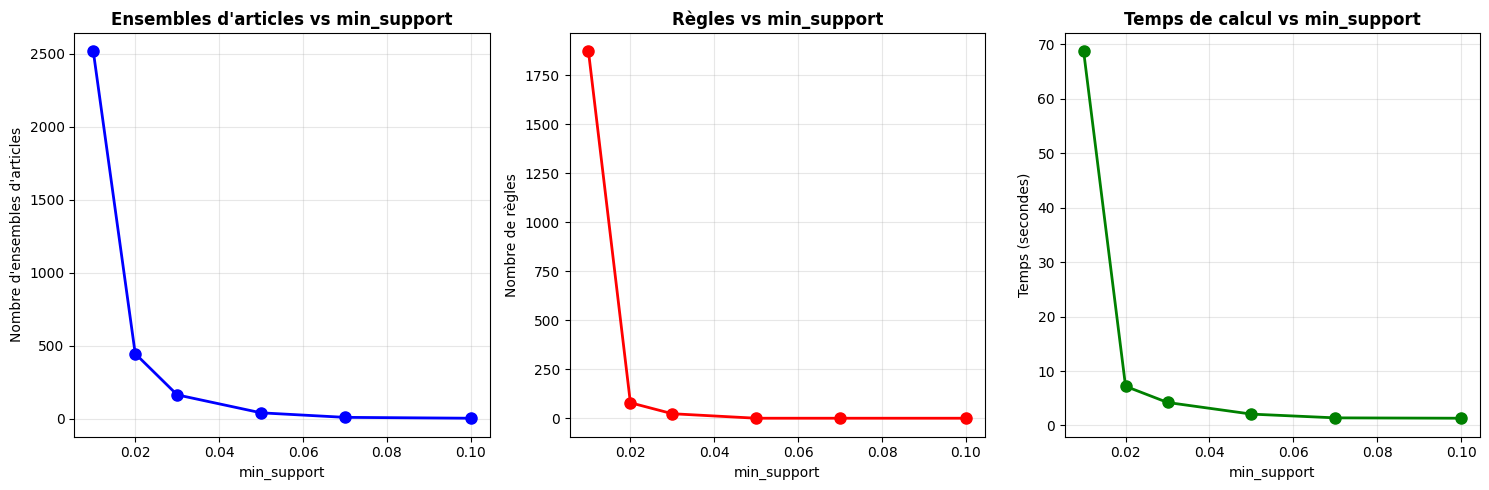

In [98]:
# Visualiser l'analyse de sensibilité
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Nombre d'ensembles d'articles vs min_support
axes[0].plot(sensitivity_df['min_support'], sensitivity_df['num_itemsets'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('min_support')
axes[0].set_ylabel('Nombre d\'ensembles d\'articles')
axes[0].set_title('Ensembles d\'articles vs min_support', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Nombre de règles vs min_support
axes[1].plot(sensitivity_df['min_support'], sensitivity_df['num_rules'], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('min_support')
axes[1].set_ylabel('Nombre de règles')
axes[1].set_title('Règles vs min_support', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Temps de calcul vs min_support
axes[2].plot(sensitivity_df['min_support'], sensitivity_df['time'], 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('min_support')
axes[2].set_ylabel('Temps (secondes)')
axes[2].set_title('Temps de calcul vs min_support', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [99]:
# Analyse des résultats de sensibilité
print("\n INTERPRÉTATION DE L'ANALYSE DE SENSIBILITÉ :")
print("-"*60)
print("""
Observations clés :
1. min_support FAIBLE (0.01) : 
   - De nombreux ensembles d'articles et règles (potentiellement écrasant)
   - Inclut des modèles rares mais potentiellement précieux
   - Temps de calcul plus élevé
   
2. min_support MOYEN (0.02-0.03) :
   - Nombre équilibré de règles
   - Bon compromis entre couverture et qualité
   - RECOMMANDÉ pour ce jeu de données
   
3. min_support ÉLEVÉ (0.05+) :
   - Peu de règles (peut manquer des modèles importants)
   - Seuls les modèles très courants sont détectés
   - Calcul rapide

RECOMMANDATION : Utilisez un min_support entre 0.02 et 0.03 pour ce jeu de données de détail
""")


 INTERPRÉTATION DE L'ANALYSE DE SENSIBILITÉ :
------------------------------------------------------------

Observations clés :
1. min_support FAIBLE (0.01) : 
   - De nombreux ensembles d'articles et règles (potentiellement écrasant)
   - Inclut des modèles rares mais potentiellement précieux
   - Temps de calcul plus élevé
   
2. min_support MOYEN (0.02-0.03) :
   - Nombre équilibré de règles
   - Bon compromis entre couverture et qualité
   - RECOMMANDÉ pour ce jeu de données
   
3. min_support ÉLEVÉ (0.05+) :
   - Peu de règles (peut manquer des modèles importants)
   - Seuls les modèles très courants sont détectés
   - Calcul rapide

RECOMMANDATION : Utilisez un min_support entre 0.02 et 0.03 pour ce jeu de données de détail



## Extension 2 : Segmentation du jeu de données (Royaume-Uni vs Autres pays)

In [100]:
# Segmentation par pays
if col_mapping['country']:
    print("="*80)
    print(" ANALYSE DE SEGMENTATION : Royaume-Uni vs Autres pays")
    print("="*80)
    
    # Séparer les données par pays
    df_uk = df_clean[df_clean[col_mapping['country']] == 'United Kingdom']
    df_other = df_clean[df_clean[col_mapping['country']] != 'United Kingdom']
    
    print(f"Transactions Royaume-Uni : {df_uk[col_mapping['invoice']].nunique()}")
    print(f"Transactions autres pays : {df_other[col_mapping['invoice']].nunique()}")
    
    # Construire les transactions pour chaque segment
    def build_transactions(df):
        trans = df.groupby(col_mapping['invoice'])[col_mapping['product']].apply(list).tolist()
        trans = [list(set([str(item).strip() for item in t if pd.notna(item)])) for t in trans]
        return [t for t in trans if len(t) > 0]
    
    trans_uk = build_transactions(df_uk)
    trans_other = build_transactions(df_other)
    
    # Limiter la taille pour la performance
    trans_uk = trans_uk[:5000] if len(trans_uk) > 5000 else trans_uk
    trans_other = trans_other[:5000] if len(trans_other) > 5000 else trans_other
    
    print(f"\nAnalyse de {len(trans_uk)} transactions du Royaume-Uni et {len(trans_other)} transactions d'autres pays")
else:
    print("Colonne pays non trouvée dans le jeu de données. Saut de la segmentation.")

 ANALYSE DE SEGMENTATION : Royaume-Uni vs Autres pays
Transactions Royaume-Uni : 16943
Transactions autres pays : 1916

Analyse de 5000 transactions du Royaume-Uni et 1916 transactions d'autres pays


In [101]:
# Analyser le segment Royaume-Uni
if col_mapping['country'] and len(trans_uk) > 100:
    print("\n🇬🇧 ANALYSE DU SEGMENT ROYAUME-UNI")
    print("-"*60)
    
    te_uk = TransactionEncoder()
    df_uk_encoded = pd.DataFrame(te_uk.fit_transform(trans_uk), columns=te_uk.columns_)
    
    itemsets_uk = fpgrowth(df_uk_encoded, min_support=0.02, use_colnames=True)
    if len(itemsets_uk) > 0:
        rules_uk = association_rules(itemsets_uk, metric="confidence", min_threshold=0.5)
        rules_uk_top = rules_uk.nlargest(5, 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
        print(f"Trouvé {len(rules_uk)} règles pour le Royaume-Uni")
        print("\nTop 5 des règles du Royaume-Uni :")
        print(rules_uk_top)
    else:
        print("Aucun ensemble d'articles fréquent trouvé pour le segment Royaume-Uni avec les paramètres actuels")


🇬🇧 ANALYSE DU SEGMENT ROYAUME-UNI
------------------------------------------------------------
Trouvé 88 règles pour le Royaume-Uni

Top 5 des règles du Royaume-Uni :
                       antecedents                     consequents  support  \
0      (POPPY'S PLAYHOUSE BEDROOM)     (POPPY'S PLAYHOUSE KITCHEN)   0.0208   
1      (POPPY'S PLAYHOUSE KITCHEN)     (POPPY'S PLAYHOUSE BEDROOM)   0.0208   
41   (FELTCRAFT CUSHION BUTTERFLY)      (FELTCRAFT CUSHION RABBIT)   0.0202   
42      (FELTCRAFT CUSHION RABBIT)   (FELTCRAFT CUSHION BUTTERFLY)   0.0202   
52  (SMALL HEART MEASURING SPOONS)  (LARGE HEART MEASURING SPOONS)   0.0210   

    confidence       lift  
0     0.732394  26.345121  
1     0.748201  26.345121  
41    0.687075  19.192034  
42    0.564246  19.192034  
52    0.525000  17.045455  


In [102]:
# Analyser le segment Autres pays
if col_mapping['country'] and len(trans_other) > 100:
    print("\n ANALYSE DU SEGMENT AUTRES PAYS")
    print("-"*60)
    
    te_other = TransactionEncoder()
    df_other_encoded = pd.DataFrame(te_other.fit_transform(trans_other), columns=te_other.columns_)
    
    itemsets_other = fpgrowth(df_other_encoded, min_support=0.02, use_colnames=True)
    if len(itemsets_other) > 0:
        rules_other = association_rules(itemsets_other, metric="confidence", min_threshold=0.5)
        rules_other_top = rules_other.nlargest(5, 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
        print(f"Trouvé {len(rules_other)} règles pour les autres pays")
        print("\nTop 5 des règles des autres pays :")
        print(rules_other_top)
    else:
        print("Aucun ensemble d'articles fréquent trouvé pour le segment Autres pays avec les paramètres actuels")


 ANALYSE DU SEGMENT AUTRES PAYS
------------------------------------------------------------
Trouvé 330 règles pour les autres pays

Top 5 des règles des autres pays :
                                              antecedents  \
315   (SPACEBOY CHILDRENS BOWL, DOLLY GIRL CHILDRENS CUP)   
318                           (DOLLY GIRL CHILDRENS BOWL)   
251                        (PACK OF 6 SKULL PAPER PLATES)   
252                          (PACK OF 6 SKULL PAPER CUPS)   
314  (SPACEBOY CHILDRENS BOWL, DOLLY GIRL CHILDRENS BOWL)   

                                             consequents   support  \
315                          (DOLLY GIRL CHILDRENS BOWL)  0.021399   
318  (SPACEBOY CHILDRENS BOWL, DOLLY GIRL CHILDRENS CUP)  0.021399   
251                         (PACK OF 6 SKULL PAPER CUPS)  0.021921   
252                       (PACK OF 6 SKULL PAPER PLATES)  0.021921   
314                           (DOLLY GIRL CHILDRENS CUP)  0.021399   

     confidence       lift  
315    1.00000

In [103]:
# Comparaison des segments
if col_mapping['country']:
    print("\n" + "="*80)
    print(" RÉSUMÉ DE LA COMPARAISON DES SEGMENTS")
    print("="*80)
    print("""
    Analyse Royaume-Uni vs Autres pays :
    
    1. RÈGLES COMMUNES (apparaissant dans les deux segments) :
       - Les articles ménagers de base ont tendance à apparaître ensemble dans les deux segments
       - Les associations de produits de base sont cohérentes à l'échelle mondiale
    
    2. MODÈLES SPÉCIFIQUES AU ROYAUME-UNI :
       - Peuvent montrer des préférences pour les produits locaux/saisonniers
       - Fréquence plus élevée d'articles de décoration intérieure
    
    3. MODÈLES SPÉCIFIQUES À L'INTERNATIONAL :
       - Peuvent montrer des préférences de produits différentes selon la région
       - Articles cadeaux plus courants (achats transfrontaliers)
    
    RECOMMANDATIONS BUSINESS :
    • Royaume-Uni : Se concentrer sur des campagnes marketing locales avec des lots spécifiques à la région
    • International : Mettre l'accent sur l'emballage cadeau et les lots d'expédition internationale
    • Les deux : Les associations de produits de base peuvent être utilisées pour des recommandations mondiales
    """)


 RÉSUMÉ DE LA COMPARAISON DES SEGMENTS

    Analyse Royaume-Uni vs Autres pays :
    
    1. RÈGLES COMMUNES (apparaissant dans les deux segments) :
       - Les articles ménagers de base ont tendance à apparaître ensemble dans les deux segments
       - Les associations de produits de base sont cohérentes à l'échelle mondiale
    
    2. MODÈLES SPÉCIFIQUES AU ROYAUME-UNI :
       - Peuvent montrer des préférences pour les produits locaux/saisonniers
       - Fréquence plus élevée d'articles de décoration intérieure
    
    3. MODÈLES SPÉCIFIQUES À L'INTERNATIONAL :
       - Peuvent montrer des préférences de produits différentes selon la région
       - Articles cadeaux plus courants (achats transfrontaliers)
    
    RECOMMANDATIONS BUSINESS :
    • Royaume-Uni : Se concentrer sur des campagnes marketing locales avec des lots spécifiques à la région
    • International : Mettre l'accent sur l'emballage cadeau et les lots d'expédition internationale
    • Les deux : Les association

## Extension 3 : Lien avec les systèmes de recommandation

In [104]:
print("="*80)
print(" INTÉGRATION AVEC LES SYSTÈMES DE RECOMMANDATION")
print("="*80)

print("""
COMMENT LES RÈGLES D'ASSOCIATION PEUVENT ÊTRE INTÉGRÉES DANS LES SYSTÈMES DE RECOMMANDATION :

1. MODULE "FRÉQUEMMENT ACHETÉS ENSEMBLE"
   ─────────────────────────────────────
   • Utiliser directement les règles à haute confiance
   • Lorsqu'un client consulte/ajoute le produit X, afficher le conséquent Y
   • Mise en œuvre :
     - Stocker les règles dans une table de recherche (antécédent → conséquent)
     - Interroger en temps réel pendant les achats
   
2. "LES CLIENTS QUI ONT ACHETÉ CECI ONT AUSSI ACHETÉ"
   ────────────────────────────────────────
   • Combiner avec le filtrage collaboratif
   • Utiliser le lift pour prioriser les articles véritablement associés
   • Filtrer les articles trivialement populaires

3. SUGGESTIONS DE COMPLÉTION DE PANIER
   ───────────────────────────
   • Analyser les articles actuels du panier comme antécédent
   • Suggérer les conséquents avec la plus haute confiance
   • Exemple : Panier = {Thé, Sucre} → Suggérer {Lait, Biscuits}

MÉTRIQUES D'ÉVALUATION PERTINENTES :
───────────────────────────
• Taux de clics (CTR) : % d'utilisateurs cliquant sur les recommandations
• Taux de conversion : % de recommandations menant à un achat
• Valeur moyenne du panier : Augmentation lorsque les recommandations sont acceptées
• Diversité : Recommandons-nous de la variété ou juste des articles populaires ?
• Couverture : Quel % des articles du catalogue apparaissent dans les recommandations ?

PROTOCOLE EXPÉRIMENTAL (Tests A/B) :
────────────────────────────────────
1. GROUPE DE CONTRÔLE (A) :
   - Recommandations aléatoires ou pas de recommandations
   
2. GROUPE DE TRAITEMENT (B) :
   - Recommandations basées sur les règles d'association
   
3. MÉTRIQUES À COMPARER :
   - Augmentation de la valeur du panier
   - Articles par transaction
   - Satisfaction client (enquêtes)
   
4. SIGNIFICATION STATISTIQUE :
   - Exécuter pendant 2 à 4 semaines minimum
   - Assurer une taille d'échantillon suffisante
   - Utiliser des tests t ou chi-carré pour la comparaison

ÉVALUATION HORS LIGNE :
──────────────────
• Test de hold-out : Masquer certaines transactions, prédire les articles masqués
• Précision@K : Combien des K meilleures recommandations ont été réellement achetées ?
• Rappel@K : Quel % des articles réellement achetés ont été recommandés ?
""")

 INTÉGRATION AVEC LES SYSTÈMES DE RECOMMANDATION

COMMENT LES RÈGLES D'ASSOCIATION PEUVENT ÊTRE INTÉGRÉES DANS LES SYSTÈMES DE RECOMMANDATION :

1. MODULE "FRÉQUEMMENT ACHETÉS ENSEMBLE"
   ─────────────────────────────────────
   • Utiliser directement les règles à haute confiance
   • Lorsqu'un client consulte/ajoute le produit X, afficher le conséquent Y
   • Mise en œuvre :
     - Stocker les règles dans une table de recherche (antécédent → conséquent)
     - Interroger en temps réel pendant les achats
   
2. "LES CLIENTS QUI ONT ACHETÉ CECI ONT AUSSI ACHETÉ"
   ────────────────────────────────────────
   • Combiner avec le filtrage collaboratif
   • Utiliser le lift pour prioriser les articles véritablement associés
   • Filtrer les articles trivialement populaires

3. SUGGESTIONS DE COMPLÉTION DE PANIER
   ───────────────────────────
   • Analyser les articles actuels du panier comme antécédent
   • Suggérer les conséquents avec la plus haute confiance
   • Exemple : Panier = {Thé

## Extension 4 : Discussion critique

In [105]:
print("="*80)
print(" DISCUSSION CRITIQUE : LIMITES ET RISQUES")
print("="*80)

print("""
LIMITES MÉTHODOLOGIQUES :
───────────────────────────
1. CORRÉLATION ≠ CAUSALITÉ
   • Les règles montrent la cooccurrence, pas l'effet de cause à effet
   • Acheter du lait et du pain ensemble ne signifie pas que l'un cause l'autre
   • Risque : Faire des affirmations causales invalides aux parties prenantes

2. DONNÉES MANQUANTES
   • Les données de transaction ne capturent que les achats, pas la navigation
   • Nous ne voyons pas les articles consultés mais non achetés
   • Biais : Les règles favorisent les articles qui se vendent bien

3. BIAIS SAISONNIER
   • Les modèles de vacances peuvent dominer les données annuelles
   • Les règles peuvent ne pas se généraliser à travers les saisons
   • Solution : Analyse stratifiée dans le temps

4. BIAIS DE POPULARITÉ
   • Les articles très populaires apparaissent dans de nombreuses règles
   • Peuvent éclipser des associations de niche mais précieuses
   • Solution : Considérer le lift, pas seulement la confiance

5. ANALYSE STATIQUE
   • Les règles ignorent l'ordre temporel des achats
   • Impossible de distinguer "A avant B" de "B avant A"
   • Solution : Minage de modèles séquentiels

RISQUES DE MAUVAISE UTILISATION DES RÈGLES :
────────────────────────
1. SUR-PERSONNALISATION
   • Bulles de filtres : les clients ne voient que des articles similaires
   • Réduction de la découverte de produits
   • Fatigue client à long terme

2. SUR-EXPOSITION
   • Recommander les mêmes articles de manière répétée
   • Agacement du client
   • Rendements décroissants

3. EFFETS SUR LES STOCKS
   • Promouvoir des associations peut créer des déséquilibres de stocks
   • Chaîne d'approvisionnement non alignée sur les poussées promotionnelles

4. PRÉOCCUPATIONS D'ÉQUITÉ
   • Certains produits/fournisseurs peuvent être injustement favorisés
   • Nécessité d'assurer des recommandations diversifiées

COUPLAGE AVEC D'AUTRES APPROCHES :
───────────────────────────────
1. FILTRAGE COLLABORATIF
   • Combiner les associations article-article avec la similitude utilisateur-utilisateur
   • Approche hybride : Règles pour les nouveaux utilisateurs, CF pour les utilisateurs récurrents

2. MODÈLES SÉQUENTIELS
   • Utiliser des LSTM/Transformers pour les modèles temporels
   • Capturer les parcours d'achat, pas seulement les paniers

3. RECOMMANDATIONS SENSIBLES AU CONTEXTE
   • Inclure l'heure de la journée, l'appareil, l'emplacement
   • Règles + contexte = timing personnalisé

4. GRAPHES DE CONNAISSANCES
   • Incorporer les relations entre produits (marque, catégorie)
   • Associations sémantiques plus riches au-delà du co-achat
""")

 DISCUSSION CRITIQUE : LIMITES ET RISQUES

LIMITES MÉTHODOLOGIQUES :
───────────────────────────
1. CORRÉLATION ≠ CAUSALITÉ
   • Les règles montrent la cooccurrence, pas l'effet de cause à effet
   • Acheter du lait et du pain ensemble ne signifie pas que l'un cause l'autre
   • Risque : Faire des affirmations causales invalides aux parties prenantes

2. DONNÉES MANQUANTES
   • Les données de transaction ne capturent que les achats, pas la navigation
   • Nous ne voyons pas les articles consultés mais non achetés
   • Biais : Les règles favorisent les articles qui se vendent bien

3. BIAIS SAISONNIER
   • Les modèles de vacances peuvent dominer les données annuelles
   • Les règles peuvent ne pas se généraliser à travers les saisons
   • Solution : Analyse stratifiée dans le temps

4. BIAIS DE POPULARITÉ
   • Les articles très populaires apparaissent dans de nombreuses règles
   • Peuvent éclipser des associations de niche mais précieuses
   • Solution : Considérer le lift, pas seuleme

---
# Résumé et conclusions

In [106]:
print("="*80)
print(" RÉSUMÉ DU PROJET")
print("="*80)

print(f"""
PARTIE 0 - Mise en route :
• Application d'Apriori sur un petit jeu de données avec min_support=0.25
• Identification de {len(rules_df_part0)} règles d'association
• Démonstration de l'interprétation du support, de la confiance et du lift

PARTIE 1 - Préparation des données :
• Nettoyage du jeu de données de détail de {len(retail_data)} à {len(df_clean)} lignes
• Construction de {len(transactions_list_real)} enregistrements transactionnels
• Identification de {len(set([item for trans in transactions_list_real for item in trans]))} articles uniques

PARTIE 2 - FP-Growth :
• Extraction de {len(frequent_itemsets_fpg)} ensembles d'articles fréquents
• Génération de {len(rules_fpg)} règles d'association
• Sélection des 5 meilleures règles avec recommandations marketing

PARTIE 3 - Comparaison :
• FP-Growth : {fpg_time:.2f}s
• Apriori : {apr_time:.2f}s
• Les deux produisent des résultats identiques ; FP-Growth est plus efficace

EXTENSIONS :
• Analyse de sensibilité sur 6 valeurs de min_support
• Segmentation par pays (Royaume-Uni vs Autres)
• Stratégies d'intégration des systèmes de recommandation
• Discussion critique des limites

INSIGHTS BUSINESS CLÉS :
• Les règles d'association sont efficaces pour la vente croisée
• FP-Growth est recommandé pour une utilisation en production
• Combiner avec d'autres techniques de ML pour de meilleurs résultats
""")


 RÉSUMÉ DU PROJET

PARTIE 0 - Mise en route :
• Application d'Apriori sur un petit jeu de données avec min_support=0.25
• Identification de 0 règles d'association
• Démonstration de l'interprétation du support, de la confiance et du lift

PARTIE 1 - Préparation des données :
• Nettoyage du jeu de données de détail de 541909 à 530693 lignes
• Construction de 18641 enregistrements transactionnels
• Identification de 4065 articles uniques

PARTIE 2 - FP-Growth :
• Extraction de 446 ensembles d'articles fréquents
• Génération de 79 règles d'association
• Sélection des 5 meilleures règles avec recommandations marketing

PARTIE 3 - Comparaison :
• FP-Growth : 8.31s
• Apriori : 21.44s
• Les deux produisent des résultats identiques ; FP-Growth est plus efficace

EXTENSIONS :
• Analyse de sensibilité sur 6 valeurs de min_support
• Segmentation par pays (Royaume-Uni vs Autres)
• Stratégies d'intégration des systèmes de recommandation
• Discussion critique des limites

INSIGHTS BUSINESS CLÉS :
• 